<a href="https://colab.research.google.com/github/ciepielajan/Time_series/blob/main/sktime_01_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with sktime

In forecasting, we're interested in using past data to make temporal forward predictions. `sktime` provides common statistical forecasting algorithms and tools for building composite machine learning models.


For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.

## Preliminaries

In [ ]:
!pip -q install sktime
!pip -q install pmdarima

     |████████████████████████████████| 1.5MB 5.0MB/s 


In [ ]:
from warnings import simplefilter

import numpy as np
import pandas as pd

from sktime.datasets import load_airline
# from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

## Data
To start, we use the Box-Jenkins univariate airline data set, which shows the number of international airline
passengers per month from 1949 - 1960.

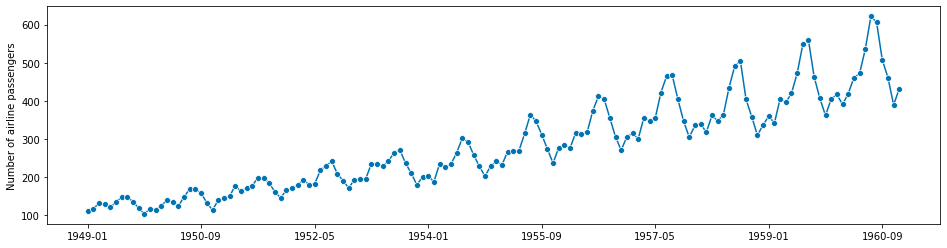

In [ ]:
y = load_airline()
plot_series(y);

A time series consists of a sequence of timepoint-value pairs, where the value represents the value we observed and the timepoint the point in time at which we observed that value.

We represent time series as a `pd.Series` where the index represents the timepoints. `sktime` supports pandas integer, period and timestamp indices. In this example, we have a period index:

In [ ]:
y.index

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Period', length=144, freq='M')

## Specifying the forecasting task

Next we will define a forecasting task.

* We will try to predict the last 3 years of data, using the previous years as training data. Each point in the series represents a month, so we should hold out the last 36 points as test data, and use 36-step ahead forecasting horizon to evaluate forecasting performance.
* We will use the sMAPE (symmetric mean absolute percentage error) to quantify the accuracy of our forecasts. A lower sMAPE means higher accuracy.

We can split the data as follows:

108 36


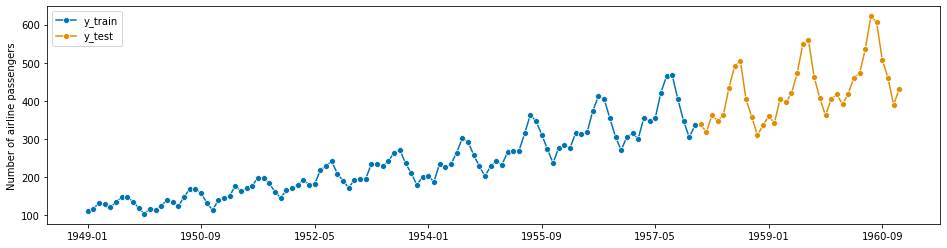

In [ ]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

When we want to generate forecasts, we need to specify the forecasting horizon and pass that to our forecasting algorithm.

#### Relative forecasting horizon
One of the simplest ways is to define a `np.array` with the steps ahead that you want to predict relative to the end of the training series.

In [ ]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

So here we're interested in predicting from the first to to the 36th step ahead. Of course you could you use other forecasting horizons. For example, to predict only the second and fifth step ahead, you could write:

```python
import numpy as np
fh = np.array([2, 5])  # 2nd and 5th step ahead
```

#### Absolute forecasting horizon
Alternatively, we can specify the forecasting horizon using the absolute time points we want to predict. In order to do that, we need to use `sktime`'s `ForecastingHorizon` class. This way, we can simply create the forecasting horizon from the time points from the test set:

In [ ]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
             '1958-07', '1958-08', '1958-09', '1958-10', '1958-11', '1958-12',
             '1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Period', freq='M', is_relative=False)

## Generating forecasts

Like in scikit-learn, in order to make forecasts, we need to first specify (or build) a model, then fit it to the training data, and finally call predict to generate forecasts for the given forecasting horizon.

`sktime` comes with several forecasting algorithms (or forecasters) and tools for composite model building. All forecaster share a common interface. Forecasters are trained on a single series of data and make forecasts for the provided forecasting horizon.

### Naïve baselines
Let's start with two naïve forecasting strategies which can serve as references for comparison of more sophisticated approaches.

#### Predicting the last value

0.2319577038795143

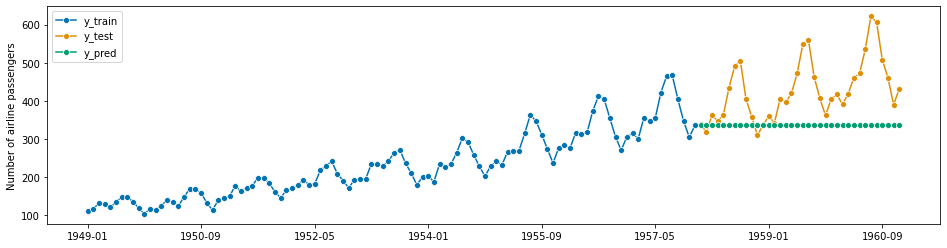

In [ ]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

#### Predicting the last value of the same season

0.145427686270316

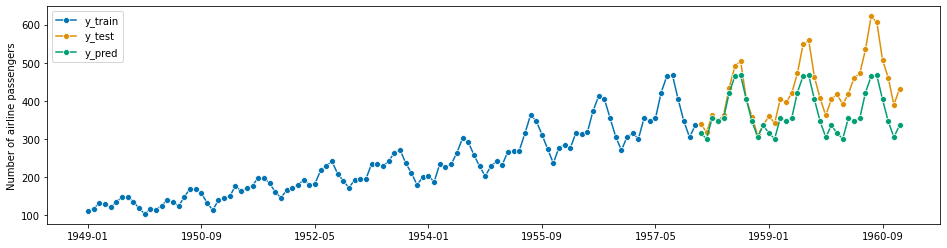

In [ ]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

## Why not just use scikit-learn?

You may wonder why we do not simply use scikit-learn for forecasting. Isn't forecasting in the end just a regression problem?

In principle, yes. But scikit-learn is not designed for solving forecasting tasks, so beware of the pitfalls!

### Pitfall 1: Model validation

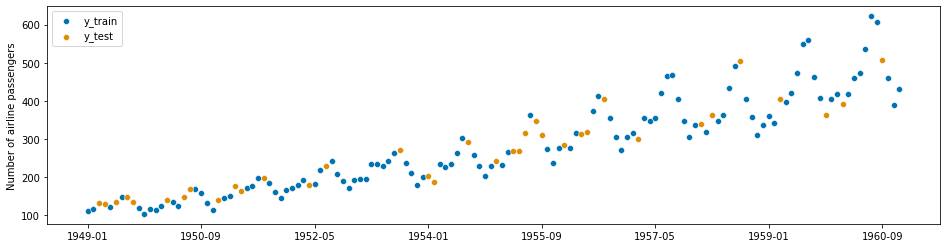

In [ ]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(y)
plot_series(y_train.sort_index(), y_test.sort_index(), labels=["y_train", "y_test"]);

This leads to leakage:

> The data you are using to train a machine learning algorithm happens to have the information you are trying to predict.

But `train_test_split(y, shuffle=False)` works, which is what `temporal_train_test_split(y)` does in `sktime`:

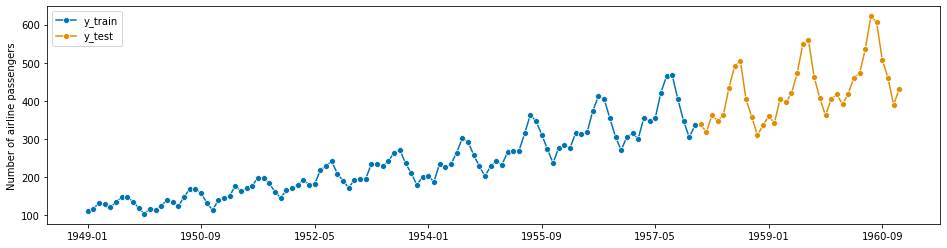

In [ ]:
y_train, y_test = temporal_train_test_split(y)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

### Pitfall 2: How exactly do we apply regression algorithms to a forecasting task?

In order to use scikit-learn, we have to first transform the data into the required tabular format, then fit a regressor and finally generate forecasts.

#### Key idea: Reduction
Forecasting is often solved via regression. This approach is sometimes called reduction, because we reduce the forecasting task to the simpler but related task of tabular regression. This allows to apply any regression algorithm to the forecasting problem.

Reduction to regression works as follows: We first need to transform the data into the required tabular format. We can do this by cutting the training series into windows of a fixed length and stacking them on top of each other. Our target variable consists of the subsequent observation for each window.

We could write some code to do that, as for example in the [M4 competition](https://github.com/Mcompetitions/M4-methods):

In [ ]:
# slightly modified code from the M4 competition
def split_into_train_test(data, in_num, fh):
    """
    Splits the series into train and test sets.

    Each step takes multiple points as inputs
    :param data: an individual TS
    :param fh: number of out of sample points
    :param in_num: number of input points for the forecast
    :return:
    """
    train, test = data[:-fh], data[-(fh + in_num) :]
    x_train, y_train = train[:-1], np.roll(train, -in_num)[:-in_num]
    x_test, y_test = test[:-1], np.roll(test, -in_num)[:-in_num]
    #     x_test, y_test = train[-in_num:], np.roll(test, -in_num)[:-in_num]

    # reshape input to be [samples, time steps, features]
    # (N-NF samples, 1 time step, 1 feature)
    x_train = np.reshape(x_train, (-1, 1))
    x_test = np.reshape(x_test, (-1, 1))
    temp_test = np.roll(x_test, -1)
    temp_train = np.roll(x_train, -1)
    for x in range(1, in_num):
        x_train = np.concatenate((x_train[:-1], temp_train[:-1]), 1)
        x_test = np.concatenate((x_test[:-1], temp_test[:-1]), 1)
        temp_test = np.roll(temp_test, -1)[:-1]
        temp_train = np.roll(temp_train, -1)[:-1]

    return x_train, y_train, x_test, y_test

In [ ]:
# here we split the time index, rather than the actual values,
# to show how we split the windows
feature_window, target_window, _, _ = split_into_train_test(
    np.arange(len(y)), 10, len(fh)
)

To better understand the prior data transformation, we can look at how we can split the training series into windows. Here we show the generated windows expressed as integer indices:

In [ ]:
feature_window[:5, :]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13]])

In [ ]:
target_window[:5]

array([10, 11, 12, 13, 14])

In [ ]:
# now we can split the actual values of the time series
x_train, y_train, x_test, y_test = split_into_train_test(y.values, 10, len(fh))
print(x_train.shape, y_train.shape)

(98, 10) (98,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

What are potential pitfalls here?

> This requires a lot of hand-written code which is often error-prone, not modular and not tuneable.

> Note also that these steps involve a number of implicit hyper-parameters:
> * the way you slice the time series into windows (e.g. the window length)
> * the way you generate forecasts (recursive strategy, direct strategy, other hybrid strategies)

### Pitfall 3: Given a fitted regression algorithm, how can we generate forecasts?

In [ ]:
print(x_test.shape, y_test.shape)

# add back time index to y_test
y_test = pd.Series(y_test, index=y.index[-len(fh) :])

(36, 10) (36,)


In [ ]:
y_pred = model.predict(x_test)
smape_loss(pd.Series(y_pred, index=y_test.index), y_test)

0.11491587994284187

But what's the problem here?

> We actually don't make a multi-step-ahead forecast up to the 36th step ahead. Instead, we make 36 single-step-ahead forecasts always using the most recent data. But that's a solution to a different learning task!

To fix this problem, we could write some code to do this recursively as in the M4 competition:

In [ ]:
# slightly modified code from the M4 study
predictions = []
last_window = x_train[-1, :].reshape(1, -1)  # make it into 2d array

last_prediction = model.predict(last_window)[0]  # take value from array

for i in range(len(fh)):
    # append prediction
    predictions.append(last_prediction)

    # update last window using previously predicted value
    last_window[0] = np.roll(last_window[0], -1)
    last_window[0, (len(last_window[0]) - 1)] = last_prediction

    # predict next step ahead
    last_prediction = model.predict(last_window)[0]

y_pred_rec = pd.Series(predictions, index=y_test.index)
smape_loss(y_pred_rec, y_test)

0.15172004645250844

## Forecasting with sktime

### Reduction: from forecasting to regression

`sktime` provides a meta-estimator for this approach, which is:

* **modular** and **compatible with scikit-learn**, so that we can easily apply any scikit-learn regressor to solve our forecasting problem,
* **tuneable**, allowing us to tune hyper-parameters like the window length or strategy to generate forecasts
* **adaptive**, in the sense that it adapts the scikit-learn's estimator interface to that of a forecaster, making sure that we can tune and properly evaluate our model

<img src="https://github.com/alan-turing-institute/sktime/blob/main/examples/img/forecasting-to-regression-reduction.png?raw=1" width="500"/>

In [ ]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
print(y_train.shape[0], y_test.shape[0])

108 36


0.14187443909112035

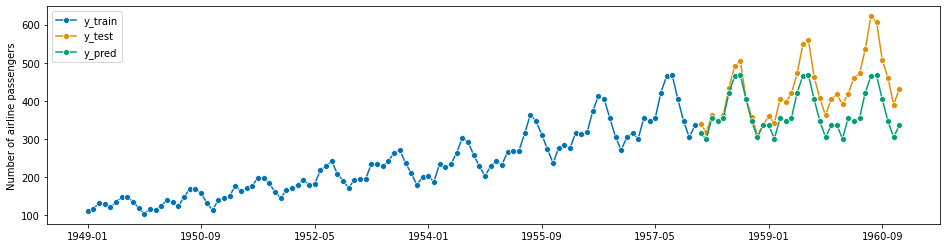

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

### Statistical forecasters

`sktime` has a number of statistical forecasting algorithms, based on implementations in statsmodels. For example, to use exponential smoothing with an additive trend component and multiplicative seasonality, we can write the following.

Note that since this is monthly data, the seasonal periodicity (sp), or the number of periods per year, is 12.

0.050276517173375584

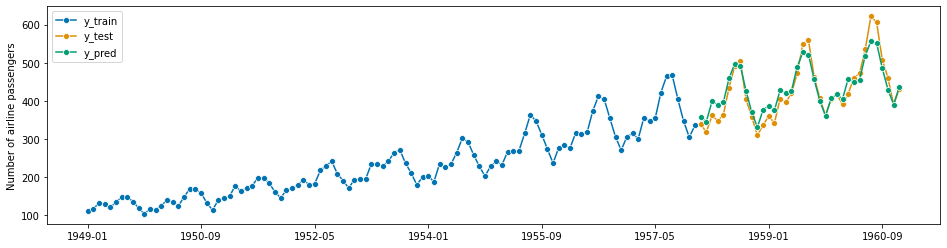

In [ ]:
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

The exponential smoothing of state space model can also be automated similar
 to the [ets](https://www.rdocumentation.org/packages/forecast/versions/8.13/topics/ets) function in R.

0.0631736567573623

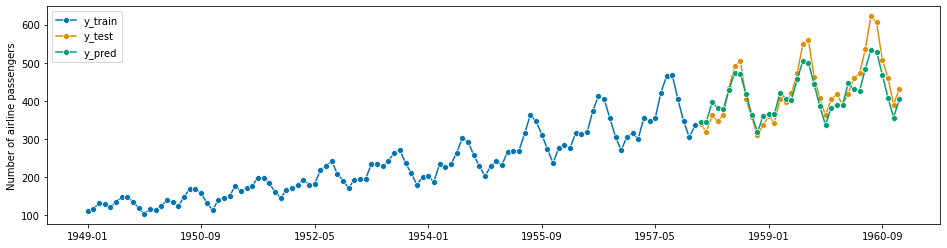

In [ ]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

Another common model is the ARIMA model. In `sktime`, we interface [`pmdarima`](https://github.com/alkaline-ml/pmdarima), a package for automatically selecting the best ARIMA model. This since searches over a number of possible model parametrisations, it may take a bit longer.

In [ ]:
!pip -q install pmdarima

In [ ]:
from pmdarima.arima import auto_arima

ValueError: ignored

In [ ]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

NameError: ignored

A single ARIMA model can also be manually configured.

0.04257105873626785

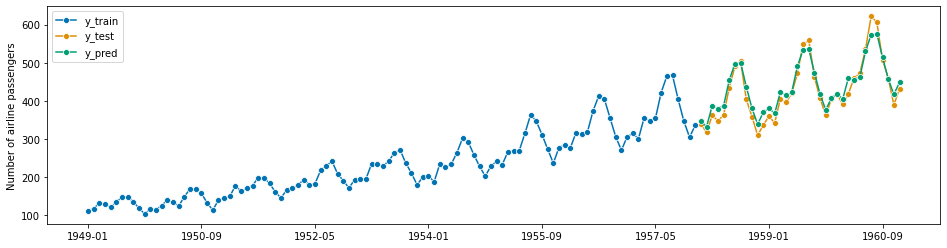

In [ ]:
forecaster = ARIMA(
    order=(1, 1, 0), seasonal_order=(0, 1, 0, 12), suppress_warnings=True
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

BATS and TBATS are two other time series forecasting algorithms that are contained in `sktime` by means of wrapping the package [`tbats`](https://github.com/intive-DataScience/tbats).

0.08689501208414034

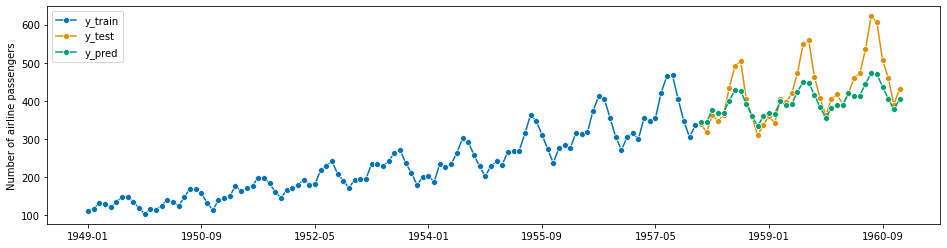

In [ ]:
from sktime.forecasting.bats import BATS

forecaster = BATS(sp=12, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.08493353477050146

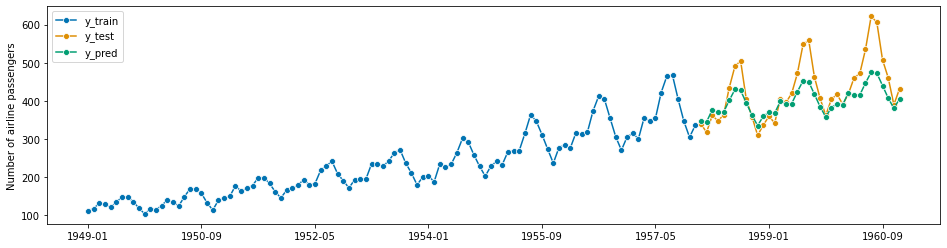

In [ ]:
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(sp=12, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

`sktime` also provides an interface to [`fbprophet`](https://github.com/facebook/prophet) by Facebook. Please note that `fbprophet` is strongly related to data with a time stamp of type `pd.DatetimeIndex`, so we have to convert the index type first:

In [ ]:
# Convert index to pd.DatetimeIndex
z = y.copy()
z = z.to_timestamp(freq="M")
z_train, z_test = temporal_train_test_split(z, test_size=36)

Importing plotly failed. Interactive plots will not work.


0.06976085803353166

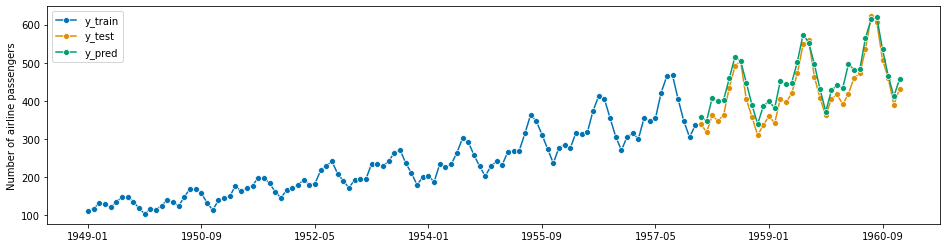

In [ ]:
from sktime.forecasting.fbprophet import Prophet

forecaster = Prophet(
    seasonality_mode="multiplicative",
    n_changepoints=int(len(y_train) / 12),
    add_country_holidays={"country_name": "Germany"},
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)
forecaster.fit(z_train)
y_pred = forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))

y_pred.index = y_test.index
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

## Composite model building

`sktime` provides a modular API for composite model building for forecasting.

### Ensembling
Like `scikit-learn`, `sktime` provides a meta-forecaster to ensemble multiple forecasting algorithms. For example, we can combine different variants of exponential smoothing as follows:

0.1902327436332568

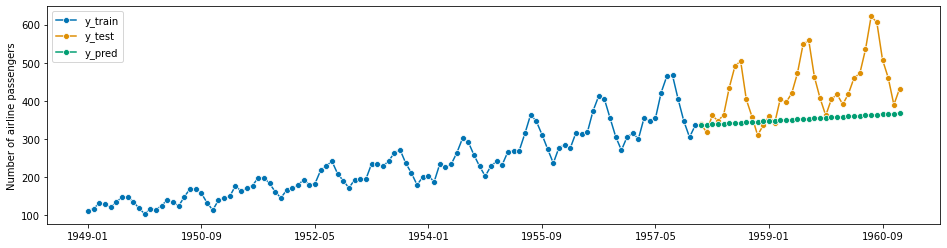

In [ ]:
ses = ExponentialSmoothing(sp=12)
holt = ExponentialSmoothing(trend="add", damped_trend=False, sp=12)
damped = ExponentialSmoothing(trend="add", damped_trend=True, sp=12)

forecaster = EnsembleForecaster(
    [
        ("ses", ses),
        ("holt", holt),
        ("damped", damped),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

### Tuning
In `make_reduction`, both the `window_length` and `strategy` arguments are
hyper-parameters which we may want to optimise.

In [ ]:
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [5, 10, 15]}

# We fit the forecaster on the initial window, and then use temporal
# cross-validation to find the optimal parameter.
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

0.145427686270316

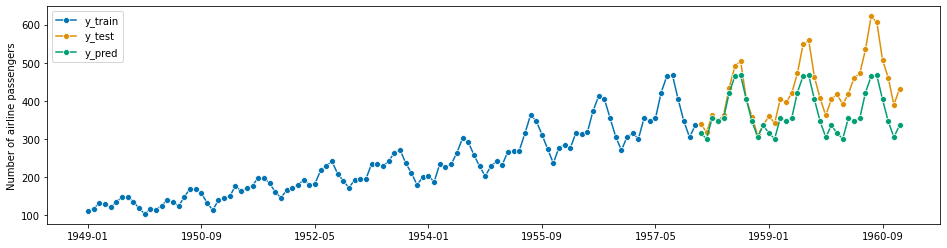

In [ ]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [ ]:
gscv.best_params_

{'window_length': 10}

### Tuning of wrapped regressor
Using scikit-learn's `GridSearchCV`, we can tune regressors imported from scikit-learn, in addition to tuning `window_length`.

0.12414004709322965

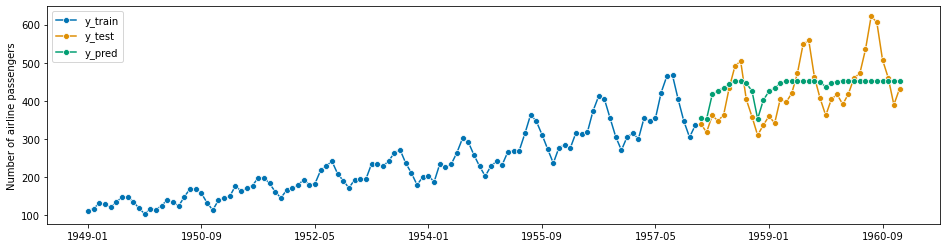

In [ ]:
from sklearn.model_selection import GridSearchCV

# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {"n_estimators": [100, 200, 300]}
forecaster_param_grid = {"window_length": [7, 12, 15]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = make_reduction(
    regressor, scitype="tabular-regressor", strategy="recursive"
)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=30)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [ ]:
print(gscv.best_params_, gscv.best_forecaster_.estimator_.best_params_)

{'window_length': 15} {'n_estimators': 100}


To access performance on a particular metric during tuning, we can use the `scoring` argument of `ForecastingGridSearchCV`.

In [ ]:
gscv = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=forecaster_param_grid, scoring=sMAPE()
)
gscv.fit(y_train)
pd.DataFrame(gscv.cv_results_)

,mean_test_sMAPE,mean_fit_time,mean_pred_time,params,rank_test_sMAPE
0,0.120987,3.000711,0.012909,{'window_length': 7},3.0
1,0.056127,3.017774,0.012518,{'window_length': 12},2.0
2,0.053027,3.050786,0.012583,{'window_length': 15},1.0


### Automatic model selection using tuning plus multiplexer

For model selection, 'MultiplexForecaster' is recommended to be used with 'ForecastingGridSearchCV'. Individually, 'MultiplexForecaster' takes different sktime forecasters wrapped in argument 'forecasters' and with the argument 'selected_forecaster', it selects which forecaster to fit when 'fit' is called. The real benefit of Multiplexer is achieved When 'MultiplexForecaster' is used in conjunction with 'ForecastingGridSearchCV'. The 'selected_forecaster' argument becomes an hyperparameter of 'MultiplexForecaster'. This way 'ForecastingGridSearchCV' provides a frame for MultiplexForecaster to switch between different forecasters to find the best performing one given a training data.

The 'forecasters' argument of 'MultiplexForecaster' can take in any sktime forecaster. The functionality provided by 'MultiplexForecaster' can even be stretched by providing 'ForecastingGridSearchCV's with different estimators wrapped in 'forecasters'. This way, the process will first tune the hyperparameters of each forecaster and then return the best performing forecaster. This way, a pipeline of hyperparameter tunning and model selection can be processed by 'MultiplexForecaster'. Finally, 'MultiplexForecaster' can work with any tuner as well, since it is an sktime forecaster.



In [ ]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ]
)
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5), window_length=30)
forecaster_param_grid = {"selected_forecaster": ["ets", "naive"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv.fit(y_train)
y_pred = gscv.predict(fh)

For a single update, you can use the `update` method.

0.23195770387951434

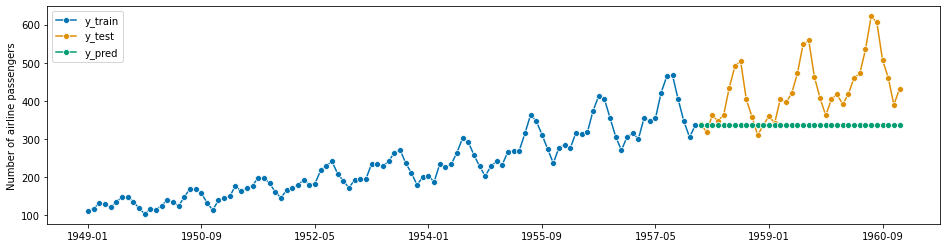

In [ ]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [ ]:
print(gscv.best_params_, "\n", gscv.best_forecaster_)

{'selected_forecaster': 'naive'} 
 MultiplexForecaster(forecasters=[('naive', NaiveForecaster()),
                                 ('ets',
                                  ExponentialSmoothing(sp=12, trend='add'))],
                    selected_forecaster='naive')


### Detrending
Note that so far the reduction approach above does not take any seasonal or trend into account, but we can easily specify a pipeline which first detrends the data.

`sktime` provides a generic detrender, a transformer which uses any forecaster and returns the in-sample residuals of the forecaster's predicted values. For example, to remove the linear trend of a time series, we can write:

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

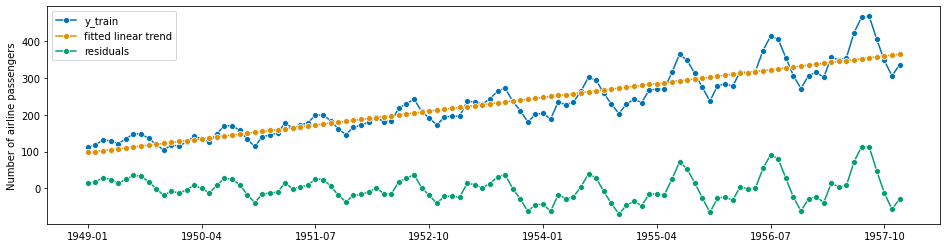

In [ ]:
# liner detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions
# of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train))  # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_series(y_train, y_pred, yt, labels=["y_train", "fitted linear trend", "residuals"]);

### Pipelining

Let's use the detrender in a pipeline together with de-seasonalisation. Note that in forecasting, when we apply data transformations before fitting, we need to apply the inverse transformation to the predicted values. For this purpose, we provide the following pipeline class:

0.05512703325752713

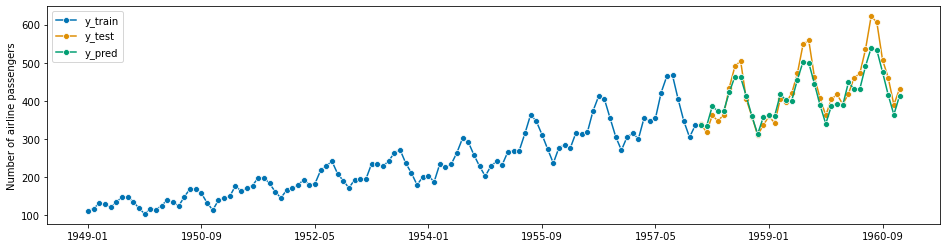

In [ ]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        (
            "forecast",
            make_reduction(
                regressor,
                scitype="tabular-regressor",
                window_length=15,
                strategy="recursive",
            ),
        ),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

Of course, we could try again to optimise the hyper-parameters of components of the pipeline.

Below we discuss two other aspects of forecasting: online learning, where we want to dynamically update forecasts as new data comes in, and prediction intervals, which allow us to quantify the uncertainty of our forecasts.

## Online Forecasting

For model evaluation, we sometimes want to evaluate multiple forecasts, using temporal cross-validation with a sliding window over the test data. For this purpose, we can leverage the forecasters from the `online_forecasting` module which use a composite forecaster, `PredictionWeightedEnsemble`, to keep track of the loss accumulated by each forecaster and create a prediction weighted by the predictions of the most "accurate" forecasters.

Note that the forecasting task is changed: we make 35 predictions since we need the first prediction to help update the weights, we do not predict 36 steps ahead.

In [ ]:
from sklearn.metrics import mean_squared_error

from sktime.forecasting.online_learning import (
    NormalHedgeEnsemble,
    OnlineEnsembleForecaster,
)

First we need to initialize a `PredictionWeightedEnsembler` that will keep track of the loss accumulated by each forecaster and define which loss function we would like to use.

In [ ]:
hedge_expert = NormalHedgeEnsemble(n_estimators=3, loss_func=mean_squared_error)

We can then create the forecaster by defining the individual forecasters and specifying the `PredictionWeightedEnsembler` we are using. Then by fitting our forecasters and performing updates and prediction with the `update_predict` function, we get:

0.15075261124309308

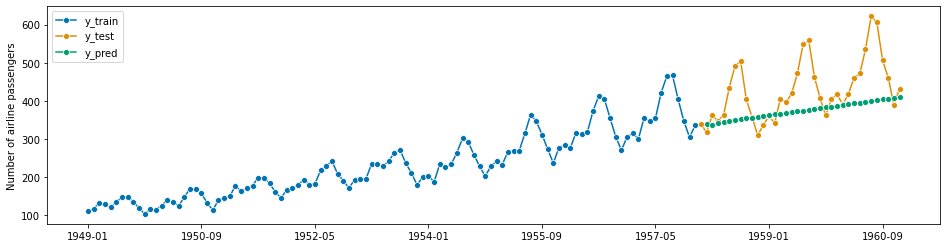

In [ ]:
forecaster = OnlineEnsembleForecaster(
    [
        ("ses", ses),
        ("holt", holt),
        ("damped", damped),
    ],
    ensemble_algorithm=hedge_expert,
)

forecaster.fit(y_train)
y_pred = forecaster.update_predict(y_test)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test[1:], y_pred)

## Prediction intervals
So far, we've only looked at point forecasts. In many cases, we're also interested in prediction intervals. `sktime`'s interface support prediction intervals, but we haven't implemented them for all algorithms yet.

Here, we use the Theta forecasting algorithm:

In [ ]:
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
smape_loss(y_test, y_pred)

0.08661467742505377

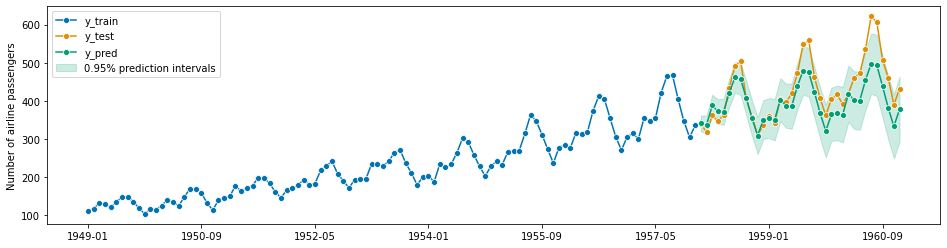

In [ ]:
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

## Model evaluation for forecasting (backtesting)
In forecasting, we usually want to know how well a forecaster would have performed in the past. This goes beyond a simple train-test-split because we want to backtest multiple fit/updates on different data. A forecaster evaluation consists at least of...
- `forecaster` that can also be a `ForecastingGridSearchCV` or `EnsembleForecaster`
- `cv` of e.g. `ExpandingWindowSplitter` or `SlidingWindowSplitter`
- `strategy` wether the forecaster should be always be refitted or just fitted once and then updated


In [ ]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
cv = ExpandingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72
)

df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)
df.iloc[:, :5]

,cutoff,fit_time,len_train_window,pred_time,test_sMAPE
0,1954-12,4.457236,72,0.006845,0.064381
1,1955-12,5.655662,84,0.006521,0.051731
2,1956-12,11.417111,96,0.005850,0.030455
3,1957-12,3.622575,108,0.004698,0.052028
4,1958-12,5.001089,120,0.006072,0.076921
5,1959-12,12.527110,132,0.006457,0.030936


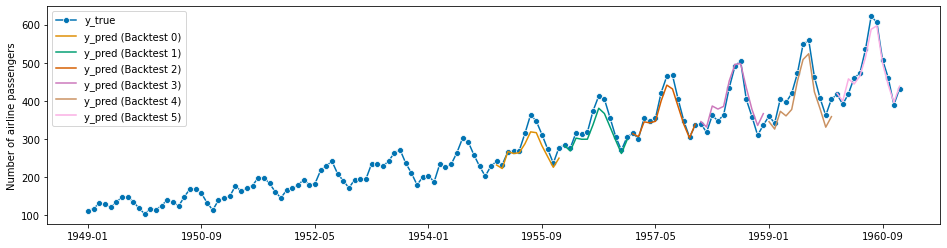

In [ ]:
# visualization of a forecaster evaluation
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

## Summary

As we have seen, in order to make forecasts, we need to first specify (or build) a model, then fit it to the training data, and finally call predict to generate forecasts for the given forecasting horizon.

* `sktime` comes with several forecasting algorithms (or forecasters) and tools for composite model building. All forecaster share a common interface. Forecasters are trained on a single series of data and make forecasts for the provided forecasting horizon.

* `sktime` has a number of statistical forecasting algorithms, based on implementations in statsmodels. For example, to use exponential smoothing with an additive trend component and multiplicative seasonality, we can write the following.


## Useful resources
* For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.
* For a good introduction to forecasting, see [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2018](https://otexts.com/fpp2/).
* For comparative benchmarking studies/forecasting competitions, see the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) and the currently running [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview).